# Slides for week 1 of PREM 4 DERG

This is a set of slides and code for week 1 of the PREM for DERG sessions.
It is a slide show to introduce PREM, to get people thinking, and to have some
code to play with.

In [1]:
import numpy as np
import scipy.integrate as spint
import matplotlib.pyplot as plt

%matplotlib inline 

# have you cited PREM?

# What is PREM

$$ M = 4\pi \int_0^{R_{e}} \rho(r) r^2 \,\mathrm{d}r.$$

In [2]:
# Show PREM plots

In [3]:
class PeicewisePolynomial(object):
    """
    Peicewise Polynomials a different way
    
    The SciPy PPoly class defines a function from
    polynomials with coefficents c and breakpoints x
    evaluated at a point xp thus:
    
       S = sum(c[m, i] * (xp - x[i])**(k-m) for m in range(k+1))
    
    This is not helpful for PREM, so we create a new class defining
    the function:
    
       S = sum(c[m, i] * (xp - x[i])**(k-m) for m in range(k+1))
      
    Note some important differences between this and PPoly!
    """
    
    def __init__(self, c, x):
        self.breakpoints = x 
        self.coeffs = c
        
        
    def __call__(self, xp, break_down=False):
        if np.ndim(xp) == 0:
            value = self._evaluate_at_point(xp, break_down)
        else:
            value = np.zeros_like(xp)
            for i in range(xp.size):
                value[i] = self._evaluate_at_point(xp[i], break_down)
        return value        
        
        
    def _evaluate_at_point(self, x, break_down=False):
        """
        Evaluate peicewise polynomal at point x
        """
        coef = self._get_coefs(x, break_down)
        value = self._evaluate_polynomial(x, coef)
        return value
        
        
    def _evaluate_polynomial(self, x, coef):
        value = 0
        for i, c in enumerate(coef):
            value = value + c * x**i
        return value
        
        
    def _get_coefs(self, x, break_down=False):
        """
        Return coefs at x
        
        If x falls on a breakpoint, we take the coeffecents from 
        'above' the breakpoint. Unless break_down is True, in which
        case we take the coeffecents from 'below'
        """
        if x == self.breakpoints[-1]:
            # We use the last coefficents for the outside point
            return self.coeffs[-1,:]
        if break_down:
            for i in range(self.breakpoints.size):
                if (x > self.breakpoints[i]) and (x <= self.breakpoints[i+1]):
                    return self.coeffs[i,:]
        else:
            for i in range(self.breakpoints.size):
                if (x >= self.breakpoints[i]) and (x < self.breakpoints[i+1]):
                    return self.coeffs[i,:]
        
        return None
    
    
    def derivative(self):
    
        deriv_breakpoints = self.breakpoints
        deriv_coeffs = np.zeros((self.coeffs.shape[0], self.coeffs.shape[1]-1))
        for seg in range(self.coeffs.shape[0]):
            for i in range(self.coeffs.shape[1]):
                if i == 0:
                    continue # Throw away term for x**0
                deriv_coeffs[seg,i-1] = self.coeffs[seg,i]*i
                
        deriv = PeicewisePolynomial(deriv_coeffs, deriv_breakpoints)
        return deriv
    
    def antiderivative(self):
        
        antideriv_breakpoints = self.breakpoints
        antideriv_coeffs = np.zeros((self.coeffs.shape[0], self.coeffs.shape[1]+1))
        for seg in range(self.coeffs.shape[0]):
            for i in range(self.coeffs.shape[1]):
                antideriv_coeffs[seg,i+1] = self.coeffs[seg,i]/(i+1)
                
        antideriv = PeicewisePolynomial(antideriv_coeffs, antideriv_breakpoints)
        return antideriv
    
    
    def integrate(self, a, b):
        
        #antiderivative = self.antiderivative()
        integral = 0
        lower_bound = a
        for bpi, bp in enumerate(self.breakpoints):
            if bp > lower_bound:
                if self.breakpoints[bpi] >= b:
                    # Just the one segment left - add it and end
                    integral = integral + (self(b, break_down=True) - self(lower_bound))
                    #print(integral, lower_bound, b, 'done')
                    break
                else:
                    # segment from lower bound to bp
                    # add it, increment lower_bound and contiue
                    integral = integral + (self(bp, break_down=True) - self(lower_bound))
                    #print(integral, lower_bound, bp)
                    lower_bound = bp

        return integral
    
    
    def mult(self, other):
        assert self.coeffs.shape[0] == other.coeffs.shape[0], 'different number of breakpoints'
        mult_breakpoints = self.breakpoints
        mult_coefs = np.zeros((self.coeffs.shape[0], self.coeffs.shape[1]+other.coeffs.shape[1]))
        for seg in range(self.coeffs.shape[0]):
            for i in range(self.coeffs.shape[1]):
                for j in range(other.coeffs.shape[1]):
                    mult_coefs[seg,i+j] = mult_coefs[seg,i+j] + self.coeffs[seg,i]*other.coeffs[seg,j]
                    
        mult_poly = PeicewisePolynomial(mult_coefs, mult_breakpoints)
        return mult_poly

In [4]:
class Prem(object):
    
    def __init__(self, breakpoints, density_params, r_earth=6371.0):
        
        self.r_earth = r_earth
        
        self.density_poly = PeicewisePolynomial(density_params, 
                                           breakpoints)
        
        # setup polynomials for mass. This is 4*pi*\int rho(r)*r^2 dr
        r2_params = np.tile(np.array([0.0, 0.0, 1000.0**3]),
                            (breakpoints.size-1,1))
        r2_poly = PeicewisePolynomial(r2_params, breakpoints)
        self.mass_poly = self.density_poly.mult(r2_poly)
        self.mass_poly = self.mass_poly.antiderivative()
        # integrating this gives mass:
        self.mass_poly.coeffs = self.mass_poly.coeffs * 4.0 * np.pi
        
        # setup polynomials for MOI. This is 2/3*4*pi*\int rho(r)*r^4 dr
        r4_params = np.tile(np.array([0.0,  0.0, 0.0, 0.0, 1000.0**5]),
                            (breakpoints.size-1,1))
        r4_poly = PeicewisePolynomial(r4_params, breakpoints)
        self.moi_poly = self.density_poly.mult(r4_poly) 
        self.moi_poly = self.moi_poly.antiderivative()
        # integrating this gives MOI:
        self.moi_poly.coeffs = self.moi_poly.coeffs * 4.0 * (2/3) * np.pi  
        
    def density(self, r):
        """
        Evaluate density in kg/m**3 at radii r (in km)
        """
        return self.density_poly(r)
    
    def mass(self, r, r_inner=0.0):
        """
        Evaluate mass inside radius r (in km)
        """
        if np.ndim(r) == 0:
            m = self.mass_poly.integrate(r_inner,r)
        else:
            m = np.zeros_like(r)
            for i in range(r.size):
                if r[i] == 0:
                    m[i] = 0
                else:
                    m[i] = self.mass_poly.integrate(r_inner,r[i])
        return m
    
    def moment_or_inertia(self, r, r_inner=0.0):
        """
        Evaluate moment of inertia inside radius r (in km)
        
        Return a tuple of moment of inertia (in kg m^2) and
        the moment of inertia factor (I/MR**2, dimensionless)
        which is 0.4 for a uniform density body, and decreases
        as the core becomes more dense than the crust/mantle.

        """
        if np.ndim(r) == 0:
            moi = self.moi_poly.integrate(r_inner,r)
        else:
            moi = np.zeros_like(r)
            for i in range(r.size):
                if r[i] == 0:
                    moi[i] = 0
                else:
                    moi[i] = self.moi_poly.integrate(r_inner,r[i])
                    
        r_in_m = r * 1000
        m = self.mass(r)
        moif = moi / (m*(r_in_m**2))
        return moi, moif
    
    def gravity(self, r):
        """
        Evaluate acceleration due to gravity at radius r in m/s^2
        """
        G = 6.6743E-11
        if np.ndim(r) == 0:
            g = self.mass_poly.integrate(0.0,r)/((r*1000)**2)*G
        else:
            g = np.zeros_like(r)
            for i in range(r.size):
                if r[i] == 0:
                    g[i] = 0
                else:
                    g[i] =  self.mass_poly.integrate(0.0,r[i])/((r[i]*1000)**2)*G        
        return g
    
    def pressure(self, r):
        """
        Evaluate pressure (in GPa) at radius r (in km)
        """
        # NB: this is done numerically, because otherise
        # I need to work out how to express g as a polynomial,
        # multiply this by rho, then do the integral inwards.
        # all a bit of a faff!
        if np.ndim(r) == 0:
            # 10 km grid spacing
            rs = np.arange(r, self.r_earth, 1.0)
            g = self.gravity(rs)
            rho = self.density(rs)
            ps = spint.cumtrapz((-g*rho)[::-1],rs[::-1]*1000.0, initial=0)
            pressure = ps[-1]/1E9
        else:
            # Assume I have been fed something I can integrate
            g = self.gravity(r)
            rho = self.density(r)
            pressure = spint.cumtrapz((-g*rho)[::-1],r[::-1]*1000.0, initial=0)
            pressure = pressure[::-1]/1E9
        return pressure

In [5]:
# This implements the PREM density model using 



# Polynomial coefficents for PREM density. 
# Note that the array is transposed to match 
# what Scipy's PPoly needs.

r_earth = 6371 # km

density_params = np.array([[13.0885,  0.0000, -8.8381,  0.0000],
                           [12.5815, -1.2638, -3.6426, -5.5281],
                           [7.9565, -6.4761,  5.5283, -3.0807],
                           [7.9565, -6.4761,  5.5283, -3.0807],
                           [7.9565, -6.4761,  5.5283, -3.0807],
                           [5.3197, -1.4836,  0.0000,  0.0000],
                           [11.2494, -8.0298,  0.0000,  0.0000],
                           [7.1089, -3.8045,  0.00002,  0.0000],
                           [2.6910,  0.6924,  0.0000,  0.0000],
                           [2.6910,  0.6924,  0.0000,  0.0000],
                           [2.9000,  0.0000,  0.0000,  0.0000],
                           [2.6000,  0.0000,  0.0000,  0.0000],
                           [1.0200,  0.0000,  0.0000,  0.0000]])


# Turn range of polynomials from 0 - 1 to 0 - r_earth (makes mass easer) 
density_params[:,0] = density_params[:,0] * 1000
density_params[:,1] = (density_params[:,1] * 1000) / r_earth 
density_params[:,2] = (density_params[:,2] * 1000) / (r_earth**2)
density_params[:,3] = (density_params[:,3] * 1000) / (r_earth**3)


# All 14 discontiuities in PREM in km.
breakpoints = np.array([0.0, 1221.5, 3480.0, 3630.0, 5600.0, 5701.0, 5771.0,
                        5971.0, 6151.0, 6291.0, 6346.6, 6356.0, 6368.0, 6371.0])



prem = Prem(breakpoints, density_params, r_earth=r_earth)

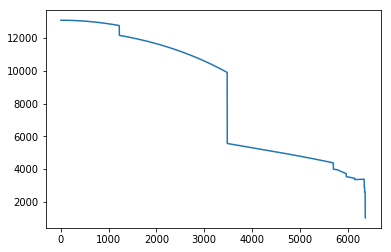

In [6]:

fig, ax = plt.subplots()

rs = np.arange(0, 6371, 0.5)
ax.plot(rs, prem.density(rs))

plt.show()

In [7]:
prem.mass(6371)

5.973178452676284e+24

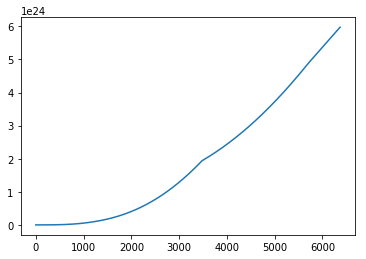

In [8]:
fig, ax = plt.subplots()

rs = np.arange(0.0, 6371.0, 10.0)
ax.plot(rs, prem.mass(rs))

plt.show()

In [9]:
print("Earth's moment of inertia is: ", prem.moment_or_inertia(6371.0)[0], "kg m^2")
print("I/MR**2:", prem.moment_or_inertia(6371)[1])

Earth's moment of inertia is:  8.020207731256643e+37 kg m^2
I/MR**2: 0.3307995553696299


In [10]:
print(prem.gravity(6371), "m/s^2")

9.821911198154554 m/s^2


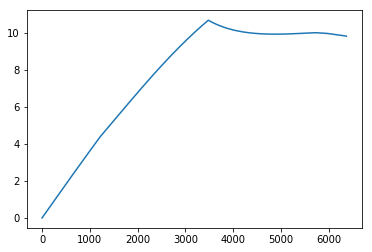

In [11]:
fig, ax = plt.subplots()

rs = np.arange(0.0, 6371.0, 10.0)
ax.plot(rs, prem.gravity(rs))

plt.show()

In [12]:
print("Pressure at center of Earth:", prem.pressure(0.0), "GPa")
print("Pressure at CMB:", prem.pressure(3480.0), "GPa")

Pressure at center of Earth: 364.04388866461255 GPa
Pressure at CMB: 135.8145751053026 GPa


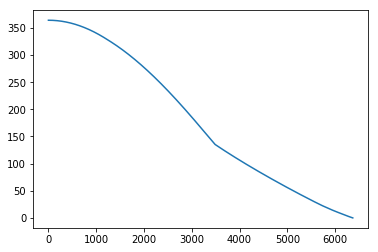

In [13]:
fig, ax = plt.subplots()

rs = np.arange(0.0, 6371.0, 0.1)
ps = prem.pressure(rs)
ax.plot(rs, ps)

plt.show()

Moment of inertia:

$$I = \frac{2}{3} 4\pi \int_0^{R_{e}} \rho(r) r^4 \,\mathrm{d}r.$$

$$g(r) = \frac{G M(r)}{r^2} $$

$$P(r) = \int_{R_e}^r -g(r) \rho(r) \,\mathrm{d}r $$